# Imports libraries and data

In [95]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import mritopng
from PIL import Image

import torch

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision.models.vgg import vgg19
import sys
sys.path.append('./Zero-Learning-Fast-Medical-Image-Fusion')
from utils import *

import shutil
import tensorflow as tf

current_path = os.getcwd()
data_path = os.path.join(current_path, 'Data\manifest-MjbMt99Q1553106146386120388')
metadata_path = os.path.join(data_path, 'metadata.csv')
info_path = os.path.join(data_path, 'INFOclinical_STS_csv.csv')
# import data
metadata = pd.read_csv(metadata_path)
info = pd.read_csv(info_path)
import cv2

# Helper Functions

In [3]:
def change_labels(label_list, label_ref):
    """
    This function changes the labels from the predicted labels to the original labels
    :param label_list: list of labels to change
    :param label_ref: list of labels to change to
    :return: list of changed labels
    """
    new_labels = []
    for label in label_list:
        new_label = label_ref[label]
        new_labels.append(new_label)
    return new_labels


# EDA and Metadata Pre-proccessing Before Image Pre-proccessing

In [16]:
info.head()

,Subject ID,MSKCC type,Site of primary STS,Grade,Time - diagnosis to MRI scan (days),Time - MRI scan to PET scan (days),Treatment,"Outcome (recurrence, mets)",Time - diagnosis to outcome (days),"Status (NED, AWD, D)",Time - diagnosis to last follow-up (days)
0,STS_001,Liposarcoma,left thigh,High,-7,4,Radiotherapy + Surgery + Chemotherapy,Mets - arms,266,D,845
1,STS_002,Leiomyosarcoma,left buttock,High,-10,25,Radiotherapy + Surgery,--,--,NED,501
2,STS_003,Other,right buttock,Intermediate,-13,15,Radiotherapy + Surgery,--,--,NED,756
3,STS_004,MFH,right thigh,Low,-6,22,Radiotherapy + Surgery,--,--,NED,1792
4,STS_005,Leiomyosarcoma,left biceps,High,-24,34,Radiotherapy + Surgery,--,--,NED,647


In [17]:
metadata.head()

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,RTstructT1,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.05 MB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:17.081
1,1.3.6.1.4.1.14519.5.2.1.5168.1900.236909650266...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,AXIAL SE T1 - RESEARCH,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,40,21.06 MB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:18.905
2,1.3.6.1.4.1.14519.5.2.1.5168.1900.269249420684...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,RTstructT2FS,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,793.95 KB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:20.531
3,1.3.6.1.4.1.14519.5.2.1.5168.1900.267475167888...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,AXIAL SE T2 FAT SAT - RESEARCH,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,40,11.89 MB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:22.271
4,1.3.6.1.4.1.14519.5.2.1.5168.1900.147597676388...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,PET CT,09-07-2000,RTstructAlignedT1toPET,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.22 MB,.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...,2022-12-04T15:17:22.541


## Check how many images per modality

,Number of Images
Modality,
CT,13607
MR,10753
PT,13617
RTSTRUCT,306


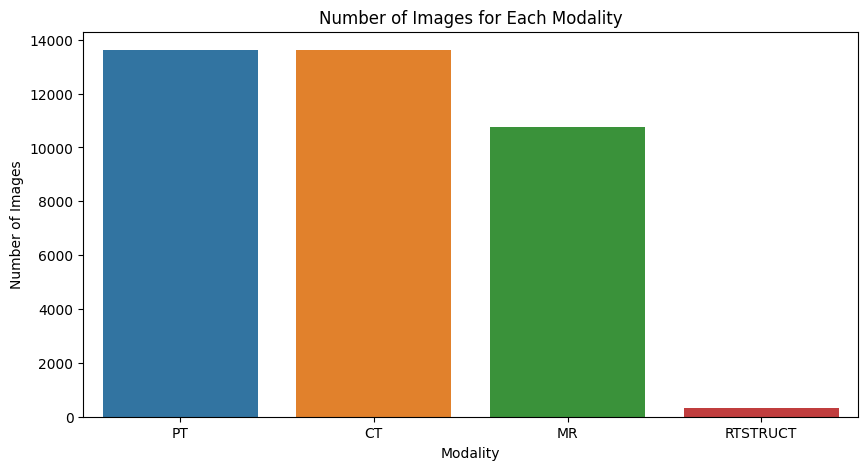

In [18]:
display(metadata[['Number of Images','Modality']].groupby('Modality').sum())
# plot the sum number of images for each modality in ascending order
plt.figure(figsize=(10,5))
sns.barplot(x='Modality', 
            y='Number of Images', 
            data=metadata[['Number of Images','Modality']]
            .groupby('Modality')
            .sum()
            .reset_index()
            .sort_values('Number of Images', ascending=False))
plt.title('Number of Images for Each Modality')
plt.show()

## Check how many subjects per MSKCC type

,Subject ID
MSKCC type,
Extraskeletal bone sarcoma,4
Fibrosarcoma,1
Leiomyosarcoma,10
Liposarcoma,11
MFH,17
Other,3
Synovial sarcoma,5


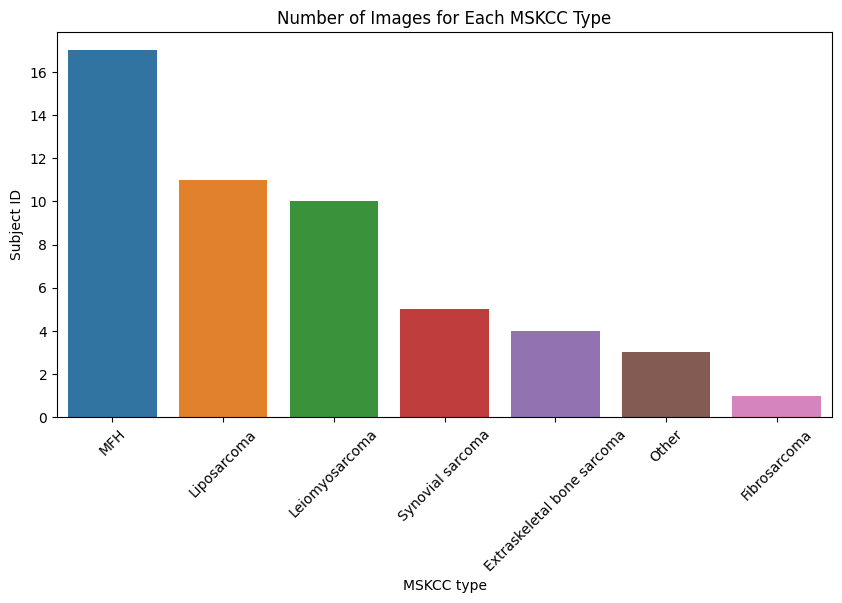

In [19]:
display(info[['Subject ID','MSKCC type']].groupby('MSKCC type').count())
# plot the number of images for each MSKCC type in ascending order
plt.figure(figsize=(10,5))
sns.barplot(x='MSKCC type',
            y='Subject ID',
            data=info[['Subject ID','MSKCC type']]
            .groupby('MSKCC type')
            .count()
            .reset_index()
            .sort_values('Subject ID', ascending=False),)
plt.xticks(rotation=45)
plt.title('Number of Images for Each MSKCC Type')
plt.show()

## Extract relevant columns from both metadataset and join them

In [20]:
meta_extracted = metadata[['Subject ID','Modality','Number of Images', 'File Location','Series Description']]
info_extracted = info[['Subject ID','MSKCC type']]

In [21]:
# join two dataframes
meta_info_join = pd.merge(meta_extracted, info_extracted, on='Subject ID', how='left')

In [22]:
meta_info_join

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type
0,STS_001,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,RTstructT1,Liposarcoma
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma
2,STS_001,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,RTstructT2FS,Liposarcoma
3,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma
4,STS_001,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...,RTstructAlignedT1toPET,Liposarcoma
...,...,...,...,...,...,...
607,STS_051,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,RTstructPET,Synovial sarcoma
608,STS_051,CT,267,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,CT IMAGES - LEGS - RESEARCH,Synovial sarcoma
609,STS_051,MR,50,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,AlignedT1toPETBOX,Synovial sarcoma
610,STS_051,MR,52,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,AlignedT2FStoPETBOX,Synovial sarcoma


## Extract MRI images and non-PETBOX images

In [23]:
# check MR images
meta_info_extracted = meta_info_join[(meta_info_join['Modality'] == 'MR') & (meta_info_join['Series Description'].str.contains('PETBOX') != True)].reset_index(drop=True)
meta_info_extracted

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type
0,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma
2,STS_002,MR,27,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,AXT1,Leiomyosarcoma
3,STS_002,MR,18,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,STIR longTE AX,Leiomyosarcoma
4,STS_003,MR,36,.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MR...,AX STIR,Other
...,...,...,...,...,...,...
97,STS_049,MR,34,.\Soft-tissue-Sarcoma\STS_049\04-14-2002-NA-MR...,Axial FSET1 LOWER TIB FIB - RESEARCH,Liposarcoma
98,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AX STIR,Leiomyosarcoma
99,STS_051,MR,48,.\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...,AXIAL FSE T2 FATSAT - RESEARCH,Synovial sarcoma
100,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AXI T1 FSE - RESEARCH,Leiomyosarcoma


## Add PNG File Location to the metadataset

In [24]:
#  png files location
file_location = meta_info_extracted['File Location'].tolist()
# add png infront of the file location
new_file_location = [x[:21] + '-png' + x[21:] for x in file_location]
meta_info_extracted['PNG File Location'] = new_file_location

## Get rid of STS_029 due to non-matching images

In [25]:
# Get rid of STS_029 due to non-matching images
meta_info_extracted = meta_info_extracted[meta_info_extracted['Subject ID'] != 'STS_029']

In [26]:
meta_info_extracted

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type,PNG File Location
0,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
2,STS_002,MR,27,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,AXT1,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...
3,STS_002,MR,18,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,STIR longTE AX,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...
4,STS_003,MR,36,.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MR...,AX STIR,Other,.\Soft-tissue-Sarcoma-png\STS_003\03-30-2005-N...
...,...,...,...,...,...,...,...
97,STS_049,MR,34,.\Soft-tissue-Sarcoma\STS_049\04-14-2002-NA-MR...,Axial FSET1 LOWER TIB FIB - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_049\04-14-2002-N...
98,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AX STIR,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...
99,STS_051,MR,48,.\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...,AXIAL FSE T2 FATSAT - RESEARCH,Synovial sarcoma,.\Soft-tissue-Sarcoma-png\STS_051\10-24-1999-N...
100,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AXI T1 FSE - RESEARCH,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...


## Check the number of images per each MSKCC type and modality

Number of Images
Modality MSKCC type                                  
MR       MFH                                     1106
         Liposarcoma                              850
         Leiomyosarcoma                           733
         Synovial sarcoma                         342
         Extraskeletal bone sarcoma               284
         Other                                    176
         Fibrosarcoma                             100

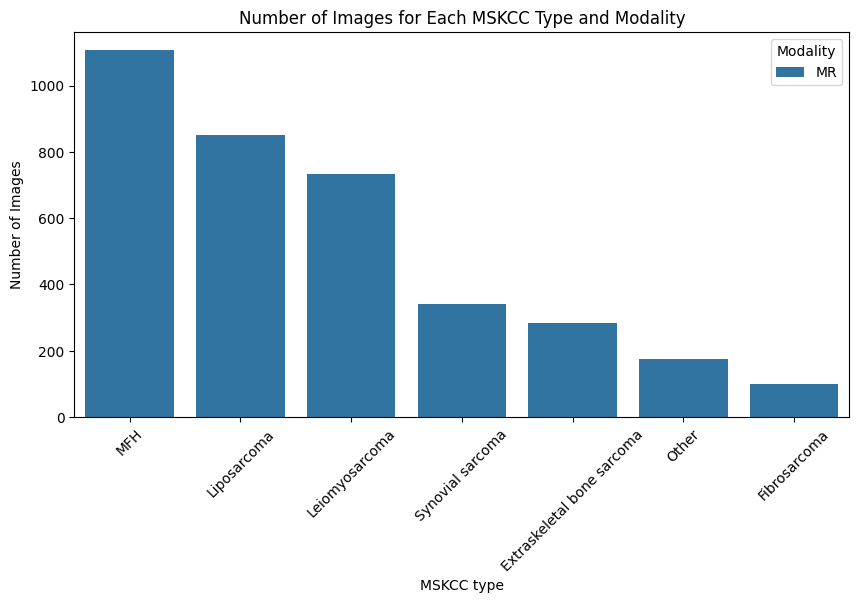

In [27]:
display(meta_info_extracted[['Modality', 'MSKCC type', 'Number of Images']]
 .groupby(['Modality', 'MSKCC type'])
 .sum()
 .sort_values('Number of Images', ascending=False))
#  plot 
plt.figure(figsize=(10,5))
sns.barplot(x='MSKCC type',
            y='Number of Images',
            hue='Modality',
            data=meta_info_extracted[['Modality', 'MSKCC type', 'Number of Images']]
            .groupby(['Modality', 'MSKCC type'])
            .sum()
            .reset_index()
            .sort_values('Number of Images', ascending=False))
plt.xticks(rotation=45)
plt.title('Number of Images for Each MSKCC Type and Modality')
plt.show()

## Checkpoint creation #1

In [40]:
# Checkpoint 1: meta_info_extracted
meta_info_extracted.to_csv('csv_checkpoints\\meta_info_extracted-1.csv', index=False)

# Image Pre-proccessing

## Resume from checkpoint #1

In [42]:
# Restore checkpoint 1
meta_info_extracted = pd.read_csv('csv_checkpoints\\meta_info_extracted-1.csv')

## Convert dicom to png

In [43]:
meta_info_extracted

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type,PNG File Location
0,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
2,STS_002,MR,27,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,AXT1,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...
3,STS_002,MR,18,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,STIR longTE AX,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...
4,STS_003,MR,36,.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MR...,AX STIR,Other,.\Soft-tissue-Sarcoma-png\STS_003\03-30-2005-N...
...,...,...,...,...,...,...,...
95,STS_049,MR,34,.\Soft-tissue-Sarcoma\STS_049\04-14-2002-NA-MR...,Axial FSET1 LOWER TIB FIB - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_049\04-14-2002-N...
96,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AX STIR,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...
97,STS_051,MR,48,.\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...,AXIAL FSE T2 FATSAT - RESEARCH,Synovial sarcoma,.\Soft-tissue-Sarcoma-png\STS_051\10-24-1999-N...
98,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AXI T1 FSE - RESEARCH,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...


In [44]:
for i in range(len(meta_info_extracted)):
    try:
        mritopng.convert_folder(os.path.join(data_path, meta_info_extracted['File Location'].iloc[i])
                                , os.path.join(data_path, meta_info_extracted['PNG File Location'].iloc[i]))
    except:
        print(meta_info_extracted['File Location'].iloc[i], 'already converted')

.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-THIGH-48623\11.000000-AXIAL SE T1 - RESEARCH-12555 already converted
.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-THIGH-48623\10.000000-AXIAL SE T2 FAT SAT - RESEARCH-62438 already converted
.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-SPINE-56934\501.000000-AXT1-02298 already converted
.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-SPINE-56934\701.000000-STIR longTE AX-10990 already converted
.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MRI PELVIS C- C-15534\4.000000-AX STIR-73168 already converted
.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MRI PELVIS C- C-15534\5.000000-AX T1-51267 already converted
.\Soft-tissue-Sarcoma\STS_004\09-30-1999-NA-RIGHT THIGH C-81525\501.000000-T2ST RT - RESEARCH-20620 already converted
.\Soft-tissue-Sarcoma\STS_004\09-30-1999-NA-RIGHT THIGH C-81525\601.000000-T1 RT - RESEARCH-86077 already converted
.\Soft-tissue-Sarcoma\STS_005\05-29-2005-NA-IRM BRAS GAUCHE C-C-94418\3.000000-AXIALT1-40756 already converted
.\S

## Add Parent Directory to the metadataset

In [45]:
#  save original path
original_path = os.getcwd()

#  add a column that contain the parent directory
meta_info_extracted['Parent Directory'] = meta_info_extracted['PNG File Location'].apply(lambda x: os.path.join(data_path, x))
for i in range(len(meta_info_extracted)):
    #  move up one directory
    os.chdir(meta_info_extracted['Parent Directory'].iloc[i])
    os.chdir('..')
    #  record the child directory into the column
    parent_directory = os.getcwd()
    rel_parent_directory = os.path.relpath(parent_directory, start=data_path)
    meta_info_extracted['Parent Directory'].iloc[i] = ".\\" + rel_parent_directory

#  move back to original directory
os.chdir(original_path)

## M - Cleaned the pictures manually due to extra images that can impact image fusing

## Update file name and remove orignal file column

In [46]:
#  change the word Soft-tissue-Sarcoma-png to Soft-tissue-Sarcoma-png - Manual Cleaning
meta_info_extracted['PNG File Location'] = meta_info_extracted['PNG File Location'].str.replace('Soft-tissue-Sarcoma-png', 'STS - Manual Cleaning')
meta_info_extracted['Parent Directory'] = meta_info_extracted['Parent Directory'].str.replace('Soft-tissue-Sarcoma-png', 'STS - Manual Cleaning')
# remove image file column
meta_info_extracted = meta_info_extracted.drop(columns=['File Location'])

## Update image number

In [47]:
# join png file location with data directory and update number of images based on png files
meta_info_extracted['Number of Images'] = (meta_info_extracted['PNG File Location']
                                      .apply(lambda x: os.path.join(data_path, x))
                                      .apply(lambda x: len(os.listdir(x))))

In [48]:
meta_info_extracted

,Subject ID,Modality,Number of Images,Series Description,MSKCC type,PNG File Location,Parent Directory
0,STS_001,MR,40,AXIAL SE T1 - RESEARCH,Liposarcoma,.\STS - Manual Cleaning\STS_001\09-03-2000-NA-...,.\STS - Manual Cleaning\STS_001\09-03-2000-NA-...
1,STS_001,MR,40,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma,.\STS - Manual Cleaning\STS_001\09-03-2000-NA-...,.\STS - Manual Cleaning\STS_001\09-03-2000-NA-...
2,STS_002,MR,15,AXT1,Leiomyosarcoma,.\STS - Manual Cleaning\STS_002\01-03-2006-NA-...,.\STS - Manual Cleaning\STS_002\01-03-2006-NA-...
3,STS_002,MR,15,STIR longTE AX,Leiomyosarcoma,.\STS - Manual Cleaning\STS_002\01-03-2006-NA-...,.\STS - Manual Cleaning\STS_002\01-03-2006-NA-...
4,STS_003,MR,36,AX STIR,Other,.\STS - Manual Cleaning\STS_003\03-30-2005-NA-...,.\STS - Manual Cleaning\STS_003\03-30-2005-NA-...
...,...,...,...,...,...,...,...
95,STS_049,MR,34,Axial FSET1 LOWER TIB FIB - RESEARCH,Liposarcoma,.\STS - Manual Cleaning\STS_049\04-14-2002-NA-...,.\STS - Manual Cleaning\STS_049\04-14-2002-NA-...
96,STS_050,MR,30,AX STIR,Leiomyosarcoma,.\STS - Manual Cleaning\STS_050\01-02-2004-NA-...,.\STS - Manual Cleaning\STS_050\01-02-2004-NA-...
97,STS_051,MR,48,AXIAL FSE T2 FATSAT - RESEARCH,Synovial sarcoma,.\STS - Manual Cleaning\STS_051\10-24-1999-NA-...,.\STS - Manual Cleaning\STS_051\10-24-1999-NA-...
98,STS_050,MR,30,AXI T1 FSE - RESEARCH,Leiomyosarcoma,.\STS - Manual Cleaning\STS_050\01-02-2004-NA-...,.\STS - Manual Cleaning\STS_050\01-02-2004-NA-...


## Checkpoint creation #2

In [49]:
# Checkpoint 2: meta_info_extracted
meta_info_extracted.to_csv('csv_checkpoints\\meta_info_extracted-2.csv', index=False)

## Resizing images

## Resuming from checkpoint #2

In [ ]:
# Restore checkpoint 2
meta_info_extracted = pd.read_csv('csv_checkpoints\\meta_info_extracted-2.csv')

In [51]:
#  for each image in the png file location, resize to 224x224
for i in range(len(meta_info_extracted)):
    # png file location
    png_file_location = os.path.join(data_path, meta_info_extracted['PNG File Location'].iloc[i])
    image_list = os.listdir(png_file_location)
    for image in image_list:
        #  open image
        im = Image.open(os.path.join(png_file_location, image))
        #  resize image
        im = im.resize((224, 224))
        #  save image
        im.save(os.path.join(png_file_location, image))

## Fuse images

In [52]:
# pretrained model
def fuse_images(image_1_path, image_2_path, output_path):
    def imread(image, mode):
        return np.array(Image.open(image).convert(mode))
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    r1, eps1, r2, eps2 = 45, 0.01, 7, 1e-6
    model = vgg19(pretrained=True)
    vgg19_relus = [1, 3, 8]

    # path_to_images = ['images/IV_images/1-38.dcm.png', 'images/IV_images/1-38.dcm - Copy.png']
    path_to_images = [image_1_path, image_2_path]

    imgs = [imread(p, mode='L') for p in path_to_images]

    float_imgs = [(img / 255.).astype(np.float32) for img in imgs]
    bases, details = decompose(float_imgs)

    Wb_0 = sal_weights(imgs)
    Wb_0 = np.moveaxis(Wb_0, -1, 0)  # easier indexed in for-loop
    Wb = guided_optimize(float_imgs, Wb_0, r1, eps1)

    fused_base = weighted_sum(bases, Wb)

    tc_details = stack_to_tensor(details)
    fused_detial = cnn_detail_fusion(tc_details, model, device, relus=vgg19_relus)

    fused = np.clip(fused_base + fused_detial, 0, 1)
    fused = np.rint(fused * 255).astype(np.uint8)
    
    # save image in output path
    im = Image.fromarray(fused)
    im.save(output_path)

In [55]:
# create fuse column and have everything as false
meta_info_extracted['Fuse'] = False
while False in meta_info_extracted['Fuse'].tolist():
    #  check for the first row that is not fused
    first_fuse_row = meta_info_extracted[meta_info_extracted['Fuse'] == False].iloc[0]
    #  check for the rows that has the same parent directory and different png file location
    try:
        second_fuse_row = meta_info_extracted[(meta_info_extracted['Parent Directory'] == first_fuse_row['Parent Directory'])
                                         & (meta_info_extracted['PNG File Location'] != first_fuse_row['PNG File Location'])].iloc[0]
        if second_fuse_row.empty:
            raise Exception('Fuse Rows not found')
    except Exception as e:
        print(str(e))
    
    # fusing operations -------------------------------------------------------------------
    # list of images in the first row
    first_row_images = os.listdir(os.path.join(data_path, first_fuse_row['PNG File Location'][2:]))
    # list of images in the second row
    second_row_images = os.listdir(os.path.join(data_path, second_fuse_row['PNG File Location'][2:]))
    # make directory for fused images
    os.makedirs(os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused'), exist_ok=True)
    for image_index in range(len(first_row_images)):
        image_number = image_index + 1
        image_number = str(image_number).zfill(3)
        fuse_image_name = 'fused-' + image_number + '.png'
        #  fuse the images
        if os.path.exists(os.path.join(data_path, first_fuse_row['PNG File Location'][2:], first_row_images[image_index])) and os.path.exists(os.path.join(data_path, second_fuse_row['PNG File Location'][2:], second_row_images[image_index])):
            # if the fused image does not exist
            if not os.path.exists(os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused', fuse_image_name)):
                fuse_images(os.path.join(data_path, first_fuse_row['PNG File Location'][2:], first_row_images[image_index]),
                            os.path.join(data_path, second_fuse_row['PNG File Location'][2:], second_row_images[image_index]),
                            os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused', fuse_image_name))
    # end of fusing operations ------------------------------------------------------------
    
    #  change fuse to true for every parent directory that has the same parent directory
    meta_info_extracted.loc[meta_info_extracted['Parent Directory'] == first_fuse_row['Parent Directory'], 'Fuse'] = True

#  remove fuse column
meta_info_extracted = meta_info_extracted.drop('Fuse', axis=1)

In [56]:
#  create a new dataframe that contains the parent directory of the fused images
meta_info_fused = meta_info_extracted.drop_duplicates(subset=['Parent Directory'])

meta_info_fused.drop(['PNG File Location', 'Modality'], axis=1, inplace=True)
#  add fused after the parent direcotry
meta_info_fused['Parent Directory'] = meta_info_fused['Parent Directory'] + '\\fused'
# rename parent directory to fused image directory
meta_info_fused.rename(columns={'Parent Directory': 'Fused Image Directory'}, inplace=True)
# update image count based on the number of images in the fused image directory
try:
    for i in range(len(meta_info_fused)):
        meta_info_fused['Number of Images'].iloc[i] = len(os.listdir(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:])))
except:
    print('Error in updating image count')

## Checkpoint creation #3

In [58]:
#check point 3
meta_info_fused.to_csv( 'csv_checkpoints\\meta_info_fused-3.csv', index=False)

## Resuming from checkpoint #3

In [61]:
# resume from check point 3
meta_info_fused = pd.read_csv('csv_checkpoints\\meta_info_fused-3.csv')

## Number of Images in each MSKCC type after fusing

,Number of Images
MSKCC type,
MFH,547
Liposarcoma,421
Leiomyosarcoma,359
Synovial sarcoma,171
Extraskeletal bone sarcoma,142
Other,88
Fibrosarcoma,50


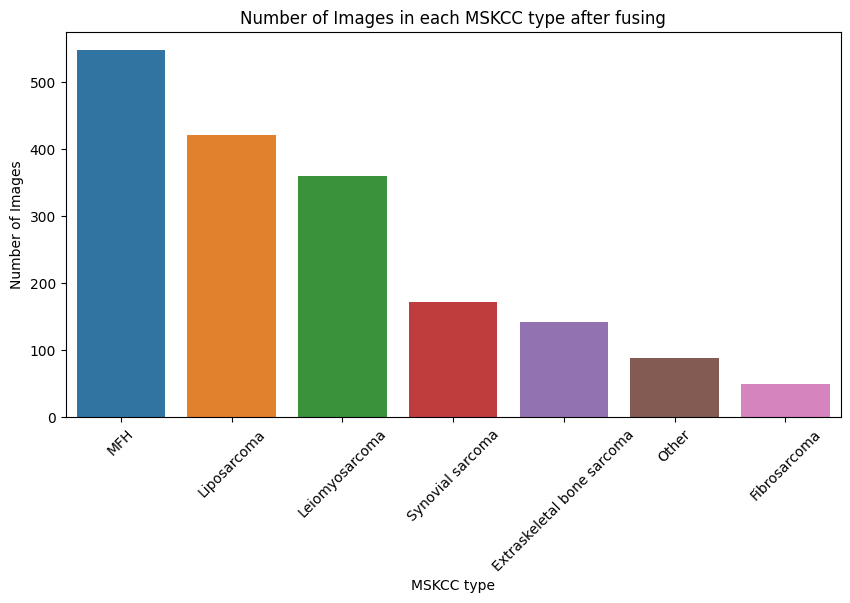

,Number of Images
MSKCC type,
MFH,547
Liposarcoma,421
Leiomyosarcoma,359
Synovial sarcoma,171
Extraskeletal bone sarcoma,142
Other,88
Fibrosarcoma,50


In [72]:
#  count number of images in based on the MSKCC type after fusing
display(meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False))

#  plot
plt.figure(figsize=(10, 5))
sns.barplot(x=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False).index,
            y=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False)['Number of Images'])
plt.xticks(rotation=45)
plt.title('Number of Images in each MSKCC type after fusing')
plt.xlabel('MSKCC type')
plt.ylabel('Number of Images')
plt.show()
display(meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False))

## Combine Fibrosarcoma to Other

In [146]:
# Combine Fibrosarcoma to Other
meta_info_fused.loc[meta_info_fused['MSKCC type'] == 'Fibrosarcoma', 'MSKCC type'] = 'Other'

,Number of Images
MSKCC type,
MFH,547
Liposarcoma,421
Leiomyosarcoma,359
Synovial sarcoma,171
Extraskeletal bone sarcoma,142
Other,138


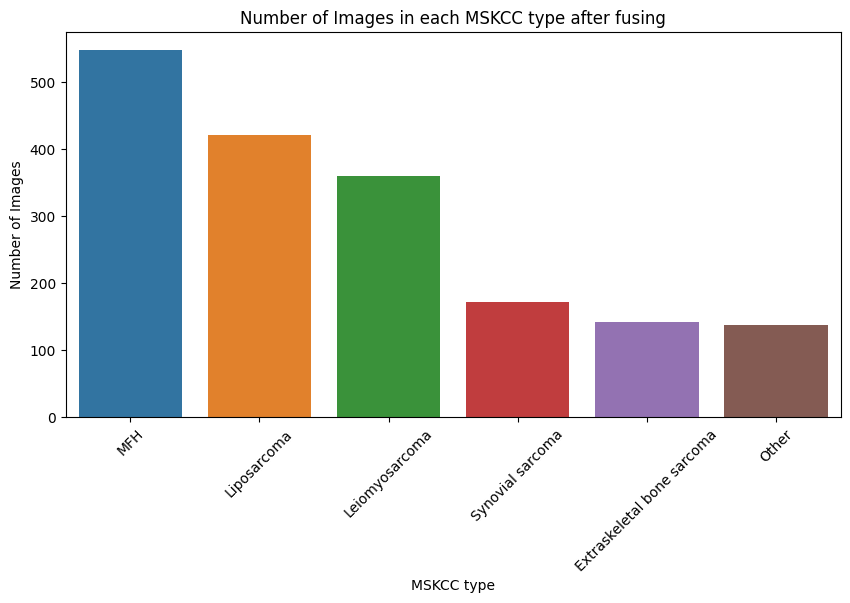

,Number of Images
MSKCC type,
MFH,547
Liposarcoma,421
Leiomyosarcoma,359
Synovial sarcoma,171
Extraskeletal bone sarcoma,142
Other,138


In [147]:
#  count number of images in based on the MSKCC type after fusing
display(meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False))

#  plot
plt.figure(figsize=(10, 5))
sns.barplot(x=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False).index,
            y=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False)['Number of Images'])
plt.xticks(rotation=45)
plt.title('Number of Images in each MSKCC type after fusing')
plt.xlabel('MSKCC type')
plt.ylabel('Number of Images')
plt.show()
display(meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False))

##  Transfer images from their respectve directories to the folder that corresponds to their MSKCC type

In [148]:
#  transfer images from their respectve directories to the folder that corresponds to their MSKCC type
new_data_path = os.path.join(data_path, 'STS-Classes-6')

leiomyosarcoma_index = 1
MFH_index = 1
liposarcoma_index = 1
SS_index = 1
EBS_index = 1
fibrosarcoma_index = 1
other_index = 1

for i in range(len(meta_info_fused)):
    #  create the new directory for the image
    os.makedirs(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i]), exist_ok=True)
    #  get the list of images in the fused image directory
    image_list = os.listdir(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:]))
    for image in image_list:
        #  transfer the image to the new directory
        shutil.copy(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:], image),
                    os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image))
        # rename the image
        if meta_info_fused['MSKCC type'].iloc[i] == 'Leiomyosarcoma':
            # zfill to 4 digits and add the index
            image_number = str(leiomyosarcoma_index).zfill(4)
            os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                        os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Leiomyosarcoma-' + image_number + '.png'))
            leiomyosarcoma_index += 1
        elif meta_info_fused['MSKCC type'].iloc[i] == 'MFH':
            # zfill to 4 digits and add the index
            image_number = str(MFH_index).zfill(4)
            os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                        os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'MFH-' + image_number + '.png'))
            MFH_index += 1
        elif meta_info_fused['MSKCC type'].iloc[i] == 'Liposarcoma':
            # zfill to 4 digits and add the index
            image_number = str(liposarcoma_index).zfill(4)
            os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                        os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Liposarcoma-' + image_number + '.png'))
            liposarcoma_index += 1
        elif meta_info_fused['MSKCC type'].iloc[i] == 'Synovial sarcoma':
            # zfill to 4 digits and add the index
            image_number = str(SS_index).zfill(4)
            os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                        os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Synovial Sarcoma-' + image_number + '.png'))
            SS_index += 1
        elif meta_info_fused['MSKCC type'].iloc[i] == 'Extraskeletal bone sarcoma':
            # zfill to 4 digits and add the index
            image_number = str(EBS_index).zfill(4)
            os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                        os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Extraskeletal Bone Sarcoma-' + image_number + '.png'))
            EBS_index += 1
        elif meta_info_fused['MSKCC type'].iloc[i] == 'Fibrosarcoma':
            # zfill to 4 digits and add the index
            image_number = str(fibrosarcoma_index).zfill(4)
            os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                        os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Fibrosarcoma-' + image_number + '.png'))
            fibrosarcoma_index += 1
        elif meta_info_fused['MSKCC type'].iloc[i] == 'Other':
            # zfill to 4 digits and add the index
            image_number = str(other_index).zfill(4)
            os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                        os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Other-' + image_number + '.png'))
            other_index += 1           

# Deep Learning Model Development

## GPU Check 

In [161]:
# Check for GPU availability
gpu_devices = tf.config.list_physical_devices("GPU")
if gpu_devices:
    for device in gpu_devices:
        print("GPU:", device)
else:
    print("No GPU available.")

# Verify GPU usage in TensorFlow
tf.config.list_physical_devices('GPU')

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Import Libraries define metrics and y columns

In [196]:
#  import train test split
from sklearn.model_selection import train_test_split

#  import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,classification_report, accuracy_score

# for hyperparameter tuning
#  keras tuner random search
from kerastuner.tuners import RandomSearch
#  import HyperModel
from kerastuner import HyperModel

# cross validation
from sklearn.model_selection import StratifiedKFold

In [163]:
def microprecision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

In [174]:
def macroprecision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)), axis=0)
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)), axis=0)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    macro_precision = tf.reduce_mean(precision)
    return macro_precision

In [165]:
# left out: 'Fibrosarcoma'
y_columns = ['Leiomyosarcoma', 'MFH', 'Liposarcoma', 'Synovial sarcoma', 'Extraskeletal bone sarcoma', 'Other']

In [166]:
PAT = 15
TUNING_PAT =5

## Image dataset preparation

### Create image_df

In [167]:
# import images from the new data path and do train test split, with their directory as their label
new_data_path = os.path.join(data_path, 'STS-Classes-6')
#  get the list of images
image_list = []
label_list = []
for root, dirs, files in os.walk(new_data_path):
    for file in files:
        if file.endswith('.png'):
            image_list.append(os.path.join(root, file))
            label_list.append(root.split('\\')[-1])

#  create a dataframe that contains the image path and their label
image_df = pd.DataFrame({'Image Path': image_list, 'Label': label_list})

# scramble the data random state 42
image_df = image_df.sample(frac=1, random_state=42).reset_index(drop=True)

### Train val test split

In [168]:
#  split the data into train and test
train_df_i, test_df = train_test_split(image_df, test_size=0.2, random_state=42, stratify=image_df['Label'])
 
#  split the train data into train and validation
train_df, val_df = train_test_split(train_df_i, test_size=0.25, random_state=42, stratify=train_df_i['Label']) # 0.25 x 0.8 = 0.2

#  one hot encode the labels
train_df = pd.concat([train_df, pd.get_dummies(train_df['Label'])], axis=1)
val_df = pd.concat([val_df, pd.get_dummies(val_df['Label'])], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Label'])], axis=1)
train_df_i = pd.concat([train_df_i, pd.get_dummies(train_df_i['Label'])], axis=1).reset_index(drop=True)

### Data Generator with Image Augmentation

In [169]:
#  create the image data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    zoom_range=[0.5, 1.5],
    fill_mode='nearest',
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
#  create the train, validation and test generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image Path',
    y_col= y_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Image Path',
    y_col= y_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image Path',
    y_col= y_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

train_generator.reset()
val_generator.reset()
test_generator.reset()

Found 1066 validated image filenames.
Found 356 validated image filenames.
Found 356 validated image filenames.


##  VGG-16 Model

In [170]:
#  create the model vgg16
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
vgg16.trainable = False

### VGG-16 attempt without hyperparameter tuning

#### Model Building

In [175]:
# create the model
model = tf.keras.models.Sequential([
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\VGG-16\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
val_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
val_generator.reset()
test_generator.reset()

Epoch 1/100
34/34 [==============================] - 11s 299ms/step - loss: 2.1366 - categorical_accuracy: 0.3105 - macroprecision: 0.1430 - microprecision: 0.3457 - val_loss: 1.5335 - val_categorical_accuracy: 0.4073 - val_macroprecision: 0.3220 - val_microprecision: 0.4988
Epoch 2/100
34/34 [==============================] - 10s 301ms/step - loss: 1.4731 - categorical_accuracy: 0.4278 - macroprecision: 0.2994 - microprecision: 0.5228 - val_loss: 1.3233 - val_categorical_accuracy: 0.4663 - val_macroprecision: 0.4067 - val_microprecision: 0.5684
Epoch 3/100
34/34 [==============================] - 10s 294ms/step - loss: 1.4087 - categorical_accuracy: 0.4634 - macroprecision: 0.4088 - microprecision: 0.6097 - val_loss: 1.4267 - val_categorical_accuracy: 0.4045 - val_macroprecision: 0.2376 - val_microprecision: 0.4526
Epoch 4/100
34/34 [==============================] - 10s 280ms/step - loss: 1.4213 - categorical_accuracy: 0.4690 - macroprecision: 0.3935 - microprecision: 0.5827 - val_lo

#### Model claasification report

12/12 [==============================] - 1s 64ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.95      0.75      0.84        28
            Leiomyosarcoma       0.84      0.81      0.82        72
               Liposarcoma       0.79      0.82      0.81        84
                       MFH       0.70      0.86      0.77       110
                     Other       0.88      0.50      0.64        28
          Synovial sarcoma       1.00      0.76      0.87        34

                  accuracy                           0.79       356
                 macro avg       0.86      0.75      0.79       356
              weighted avg       0.81      0.79      0.79       356

Macro Precision:  0.860293004121825
Micro Precision:  0.7949438202247191


Text(95.7222222222222, 0.5, 'True Labels')

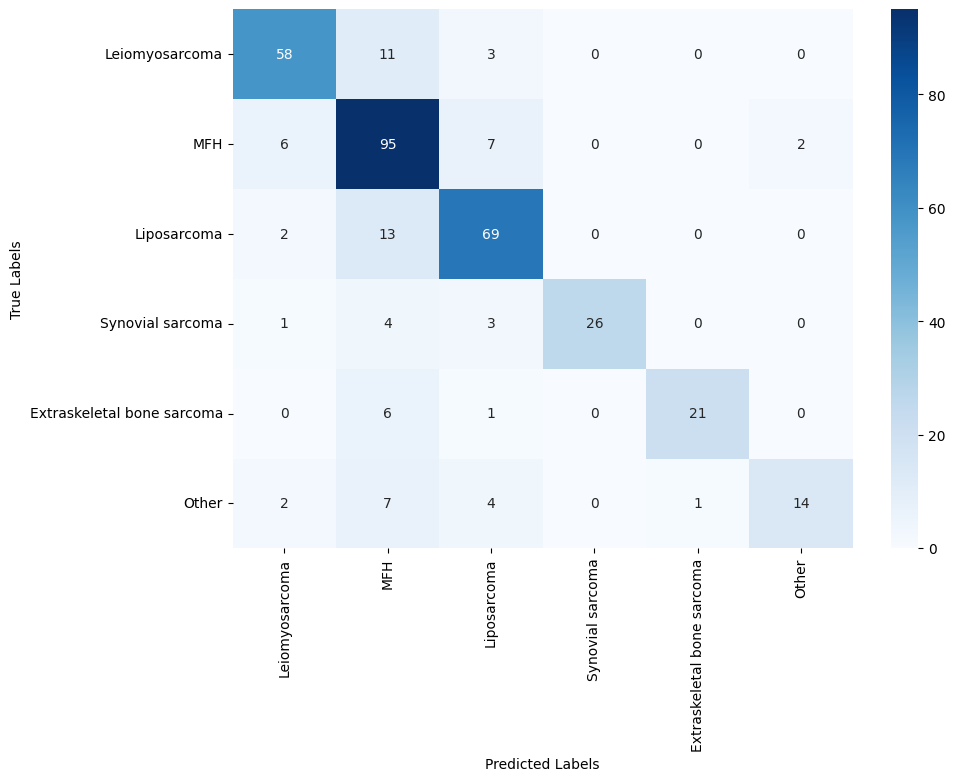

In [176]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Micro Precision')

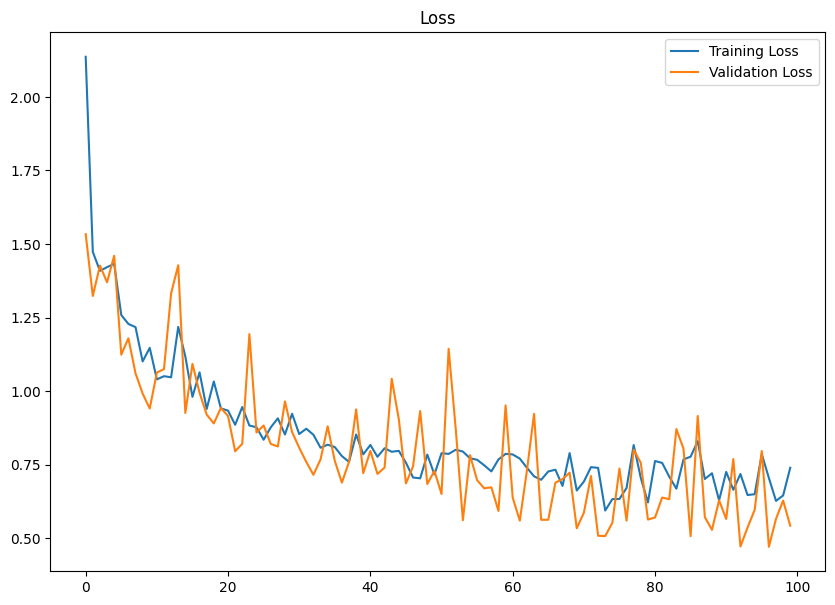

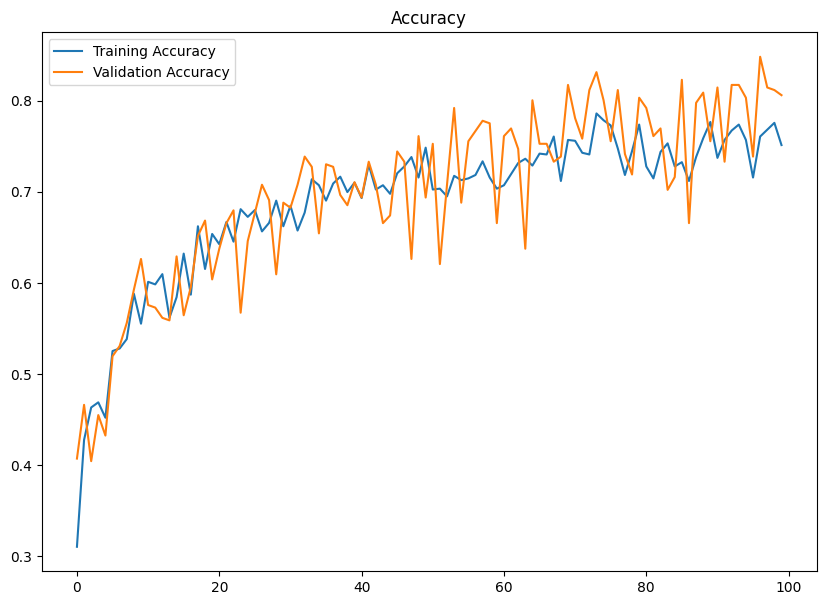

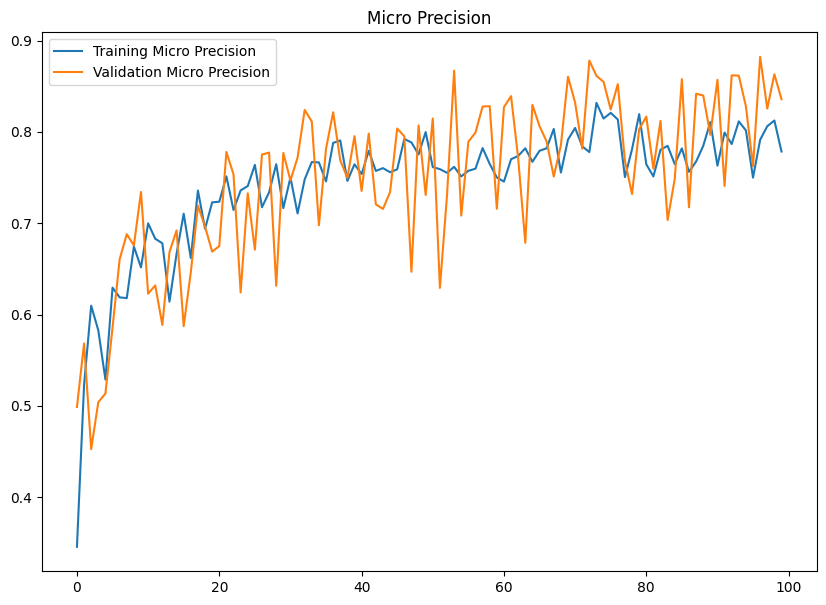

In [177]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [178]:
# save the model
model.save('models\\VGG-16\\vgg-model-test.h5')

### VGG-16 attempt with hyperparameter tuning

#### Define VGG model class

In [179]:
class VGG16Model_class(HyperModel):
    def build(self, hp):
        vgg16 = tf.keras.applications.VGG16(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )
        vgg16.trainable = False
        model = tf.keras.models.Sequential([
            vgg16,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [180]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = VGG16Model_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory='models\\VGG-16\\random_search',
    project_name='VGG-16'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = val_generator,
    callbacks=[early_stopping],
)

Trial 50 Complete [00h 09m 17s]
val_loss: 0.7235555052757263

Best val_loss So Far: 0.7102984189987183
Total elapsed time: 07h 17m 51s
INFO:tensorflow:Oracle triggered exit


#### Tuning results

In [181]:
tuner.results_summary()

Results summary
Results in models\VGG-16\random_search\VGG-16
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 15 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.001
batch_size: 32
epochs: 100
Score: 0.7102984189987183

Trial 49 summary
Hyperparameters:
dropout_rate: 0.1
learning_rate: 0.001
batch_size: 32
epochs: 100
Score: 0.7235555052757263

Trial 48 summary
Hyperparameters:
dropout_rate: 0.30000000000000004
learning_rate: 0.001
batch_size: 64
epochs: 50
Score: 0.7280642092227936

Trial 06 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.001
batch_size: 32
epochs: 50
Score: 0.7350674867630005

Trial 44 summary
Hyperparameters:
dropout_rate: 0.30000000000000004
learning_rate: 0.001
batch_size: 128
epochs: 50
Score: 0.8211560845375061

Trial 10 summary
Hyperparameters:
dropout_rate: 0.1
learning_rate: 0.001
batch_size: 32
epochs: 75
Score: 0.8552727401256561

Trial 28 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.001
batch_

In [182]:
#  get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

{'dropout_rate': 0.0, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}

#### Build the model with the best hyperparameters

##### Model Building

In [183]:
# Build the model with the best hyperparameters
vgg_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\VGG-16\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

#  fit the model
history = vgg_tuned_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()
val_generator.reset()

Epoch 1/100
34/34 [==============================] - 11s 322ms/step - loss: 2.0722 - categorical_accuracy: 0.3077 - macroprecision: 0.1451 - microprecision: 0.3625 - val_loss: 1.6529 - val_categorical_accuracy: 0.3483 - val_macroprecision: 0.1186 - val_microprecision: 0.4214
Epoch 2/100
34/34 [==============================] - 11s 314ms/step - loss: 1.5683 - categorical_accuracy: 0.4071 - macroprecision: 0.3176 - microprecision: 0.5141 - val_loss: 1.3874 - val_categorical_accuracy: 0.4438 - val_macroprecision: 0.3122 - val_microprecision: 0.5024
Epoch 3/100
34/34 [==============================] - 11s 308ms/step - loss: 1.4836 - categorical_accuracy: 0.4371 - macroprecision: 0.4018 - microprecision: 0.5494 - val_loss: 1.6036 - val_categorical_accuracy: 0.3539 - val_macroprecision: 0.3465 - val_microprecision: 0.3621
Epoch 4/100
34/34 [==============================] - 11s 315ms/step - loss: 1.3291 - categorical_accuracy: 0.4981 - macroprecision: 0.4463 - microprecision: 0.5942 - val_lo

##### Model claasification report

In [184]:
#  evaluate the model
vgg_tuned_model.evaluate(test_generator)

#  predict the test data
predictions = vgg_tuned_model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

# print  macro precision
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', macro_precision)

12/12 [==============================] - 1s 73ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.93      0.93      0.93        28
            Leiomyosarcoma       0.88      0.90      0.89        72
               Liposarcoma       0.81      0.83      0.82        84
                       MFH       0.87      0.78      0.82       110
                     Other       0.80      0.86      0.83        28
          Synovial sarcoma       0.72      0.82      0.77        34

                  accuracy                           0.84       356
                 macro avg       0.83      0.85      0.84       356
              weighted avg       0.84      0.84      0.84       356

Micro Precision:  0.8398876404494382
Macro Precision:  0.8345898136595812


##### Model History

Text(0.5, 1.0, 'Macro Precision')

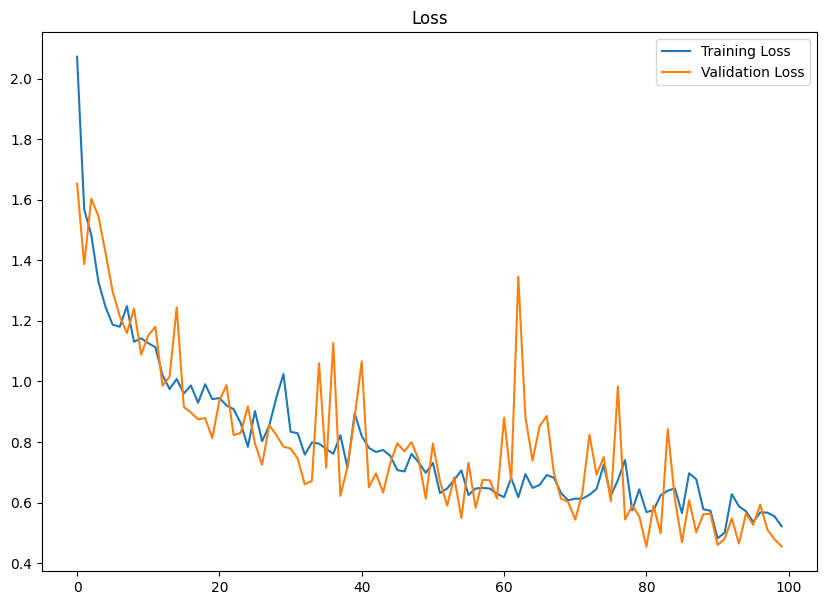

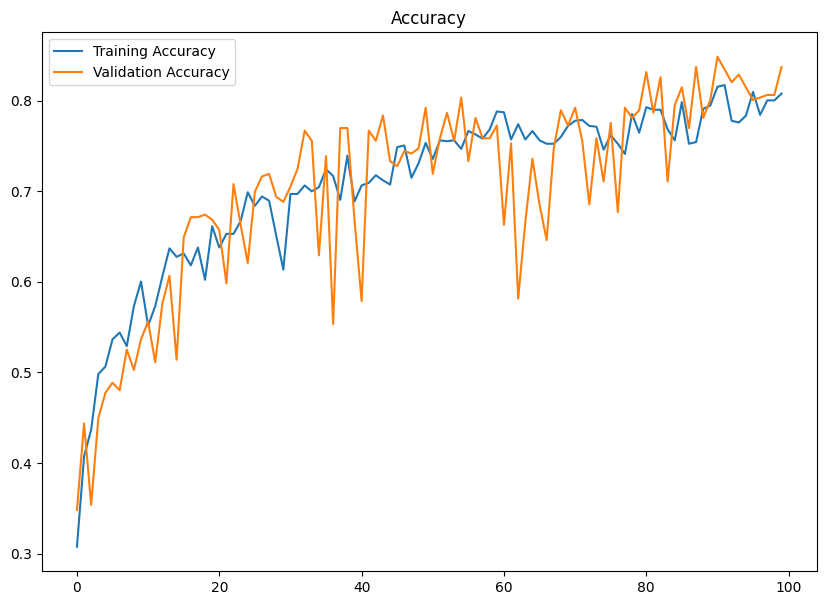

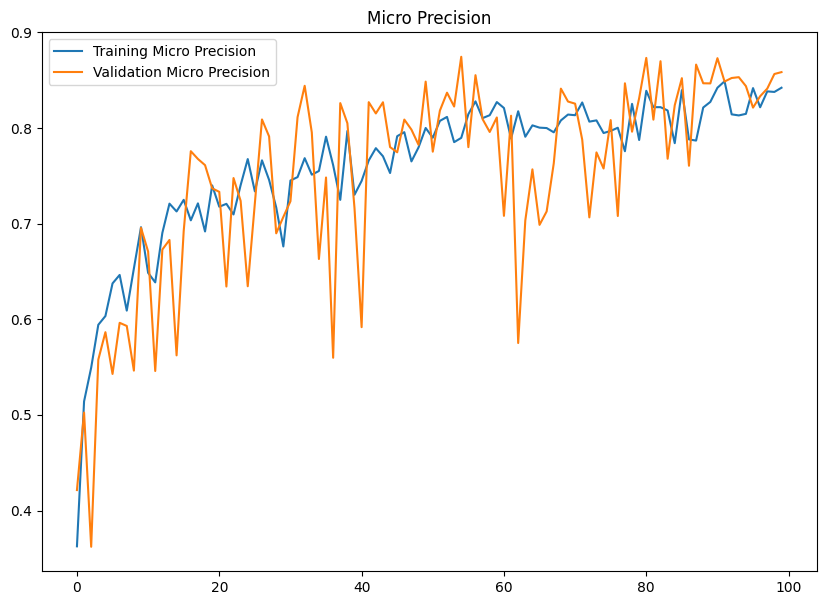

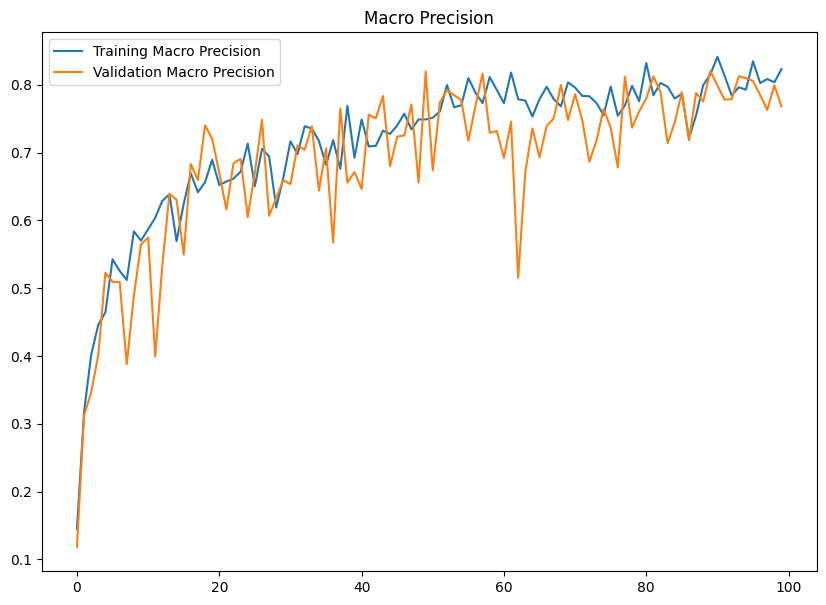

In [185]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [186]:
# save the model
vgg_tuned_model.save('models\\VGG-16\\vgg_tuned_model.h5')

### VGG-16 Cross Validation

In [210]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

i = 1
vgg_hist = []
vgg_accuracy = []
vgg_micro_precision = []
vgg_macro_precision = []
X = train_df_i['Image Path']
y = train_df_i['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\VGG-16\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df_i.iloc[train_index]
    test_data_cv  = train_df_i.iloc[test_index]
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    vgg_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    vgg_hist.append(vgg_tuned_model_cv.fit(
        train_generator,
        epochs=100,
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    vgg_tuned_model_cv.evaluate(test_generator, verbose=0)
    predictions = vgg_tuned_model_cv.predict(test_generator, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    vgg_accuracy.append(accuracy_score(true_labels, predicted_labels))
    vgg_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    vgg_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', vgg_accuracy[i-1], '\nMicro Precision: ', vgg_micro_precision[i-1], '\nMacro Precision: ', vgg_macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(accuracy))
print('Average micro precision: ', np.mean(micro_precision))
print('Average macro precision: ', np.mean(macro_precision))

--------------------------------------------------
Fold  1
--------------------------------------------------
Found 1137 validated image filenames.
Found 285 validated image filenames.

Model 1 evaluation:
Accuracy:  0.4245614035087719 
Micro Precision:  0.4245614035087719 
Macro Precision:  0.31938169286853496


--------------------------------------------------
Fold  2
--------------------------------------------------
Found 1137 validated image filenames.
Found 285 validated image filenames.

Model 2 evaluation:
Accuracy:  0.40350877192982454 
Micro Precision:  0.40350877192982454 
Macro Precision:  0.23527335595212473


--------------------------------------------------
Fold  3
--------------------------------------------------
Found 1138 validated image filenames.
Found 284 validated image filenames.

Model 3 evaluation:
Accuracy:  0.31690140845070425 
Micro Precision:  0.31690140845070425 
Macro Precision:  0.5111129770612529


--------------------------------------------------
F

## ResNet-50 Model

In [ ]:
# create restnet model
restnet_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
restnet_model.trainable = False

### ResNet-50 attempt without hyperparameter tuning

#### Model Building

In [ ]:
# create the model
model = tf.keras.models.Sequential([
    restnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\RestNet-50\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
val_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
val_generator.reset()
test_generator.reset()

#### Model Classifcation Report

In [ ]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

In [ ]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [ ]:
model.save('models\\RestNet-50\\restnet-model-test.h5')

### ResNet-50 attempt with hyperparameter tuning

#### Define ResNet model class

In [ ]:
class RestNet50Model_class(HyperModel):
    def build(self, hp):
        restnet_model = tf.keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )

        #  freeze the layers
        restnet_model.trainable = False
        model = tf.keras.models.Sequential([
            restnet_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [ ]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = RestNet50Model_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory='models\\RestNet-50\\random_search',
    project_name='RestNet-50'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = val_generator,
    callbacks=[early_stopping],
)

In [ ]:
tuner.results_summary()

In [ ]:
#  get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

#### Build the model with the best hyperparameters

##### Model Building

In [ ]:
# Build the model with the best hyperparameters
restnet_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\RestNet-50\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

#  fit the model
history = restnet_tuned_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()
val_generator.reset()

##### Model Classification Report

In [ ]:
#  evaluate the model
restnet_tuned_model.evaluate(test_generator)

#  predict the test data
predictions = restnet_tuned_model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

# print  macro precision
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', macro_precision)

##### Model History

In [ ]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [ ]:
#  save the model
restnet_tuned_model.save('models\\RestNet-50\\restnet-model-tuned.h5')

### RestNet-50 Cross Validation

In [ ]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
i = 1
rest_hist = []
rest_accuracy = []
rest_micro_precision = []
rest_macro_precision = []
X = train_df_i['Image Path']
y = train_df_i['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\RestNet-50\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df_i.iloc[train_index]
    test_data_cv  = train_df_i.iloc[test_index]
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    restnet_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    rest_hist.append(restnet_tuned_model_cv.fit(
        train_generator,
        epochs=100,
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    restnet_tuned_model_cv.evaluate(test_generator, verbose=0)
    predictions = restnet_tuned_model_cv.predict(test_generator, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    rest_accuracy.append(accuracy_score(true_labels, predicted_labels))
    rest_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    rest_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', accuracy[i-1], '\nMicro Precision: ', micro_precision[i-1], '\nMacro Precision: ', macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(rest_accuracy))
print('Average micro precision: ', np.mean(rest_micro_precision))
print('Average macro precision: ', np.mean(rest_macro_precision))

## InceptionV3 Model

In [ ]:
# create inception model
inception_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
inception_model.trainable = False

### InceptionV3 attempt without hyperparameter tuning

#### Model Building

In [ ]:
# create the model
model = tf.keras.models.Sequential([
    inception_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\InceptionV3\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
val_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
val_generator.reset()
test_generator.reset()

#### Model Classification Report

In [ ]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

In [ ]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [ ]:
# save the model
model.save('models\\InceptionV3\\inception-model-test.h5')

### InceptionV3 attempt with hyperparameter tuning

#### Define InceptionV3 model class

In [ ]:
class InceptionV3Model_class(HyperModel):
    def build(self, hp):
        inception_model = tf.keras.applications.InceptionV3(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )

        #  freeze the layers
        inception_model.trainable = False
        model = tf.keras.models.Sequential([
            inception_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [ ]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = InceptionV3Model_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory='models\\InceptionV3\\random_search',
    project_name='InceptionV3'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = val_generator,
    callbacks=[early_stopping],
)

In [ ]:
tuner.results_summary()

In [ ]:
#  get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

#### Build the model with the best hyperparameters

##### Model Building

In [ ]:
# Build the model with the best hyperparameters
inception_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\InceptionV3\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

#  fit the model
history = inception_tuned_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()
val_generator.reset()

##### Model Classification Report

In [ ]:
#  evaluate the model
inception_tuned_model.evaluate(test_generator)

#  predict the test data
predictions = inception_tuned_model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

# print  macro precision
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', macro_precision)

##### Model History

In [ ]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [ ]:
#  save the model
inception_tuned_model.save('models\\InceptionV3\\inception-model-tuned.h5')

### InceptionV3 Cross Validation

In [ ]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
i = 1
incep_hist = []
incep_accuracy = []
incep_micro_precision = []
incep_macro_precision = []
X = train_df_i['Image Path']
y = train_df_i['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\InceptionV3\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df_i.iloc[train_index]
    test_data_cv  = train_df_i.iloc[test_index]
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    inception_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    incep_hist.append(inception_tuned_model_cv.fit(
        train_generator,
        epochs=100,
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    inception_tuned_model_cv.evaluate(test_generator, verbose=0)
    predictions = inception_tuned_model_cv.predict(test_generator, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    accuracy.append(accuracy_score(true_labels, predicted_labels))
    micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', incep_accuracy[i-1], '\nMicro Precision: ', incep_micro_precision[i-1], '\nMacro Precision: ', incep_macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(incep_accuracy))
print('Average micro precision: ', np.mean(incep_micro_precision))
print('Average macro precision: ', np.mean(incep_macro_precision))

## EfficientNet Model

In [ ]:
# create efficientnet model
efficientnet_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
efficientnet_model.trainable = False

### EfficientNet attempt without hyperparameter tuning

#### Model Building

In [ ]:
# create the model
model = tf.keras.models.Sequential([
    efficientnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\EfficientNet\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
val_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
val_generator.reset()
test_generator.reset()

#### Model Classification Report

In [ ]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

In [ ]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [ ]:
model.save('models\\EfficientNet\\efficientnet-model-test.h5')

### EfficientNet attempt with hyperparameter tuning

#### Define EfficientNet model class

In [ ]:
class EfficientNetModel_class(HyperModel):
    def build(self, hp):
        efficientnet_model = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )

        #  freeze the layers
        efficientnet_model.trainable = False
        model = tf.keras.models.Sequential([
            efficientnet_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [ ]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = EfficientNetModel_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory='models\\EfficientNet\\random_search',
    project_name='EfficientNet'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = val_generator,
    callbacks=[early_stopping],
)

In [ ]:
tuner.results_summary()

In [ ]:
#  get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

#### Build the model with the best hyperparameters

##### Model Building

In [ ]:
# Build the model with the best hyperparameters
efficientnet_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\EfficientNet\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

#  fit the model
history = efficientnet_tuned_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()
val_generator.reset()

##### Model Classification Report

In [ ]:
#  evaluate the model
efficientnet_tuned_model.evaluate(test_generator)

#  predict the test data
predictions = efficientnet_tuned_model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

# print  macro precision
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', macro_precision)

##### Model History

In [ ]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [ ]:
#  save the model
restnet_tuned_model.save('models\\EfficientNet\\efficientnet-model-tuned.h5')

### EfficientNet Cross Validation

In [ ]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
i = 1
eff_hist = []
eff_accuracy = []
eff_micro_precision = []
eff_macro_precision = []
X = train_df_i['Image Path']
y = train_df_i['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\EfficientNet\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df_i.iloc[train_index]
    test_data_cv  = train_df_i.iloc[test_index]
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    efficientnet_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    eff_hist.append(efficientnet_tuned_model_cv.fit(
        train_generator,
        epochs=100,
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    efficientnet_tuned_model_cv.evaluate(test_generator, verbose=0)
    predictions = efficientnet_tuned_model_cv.predict(test_generator, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    eff_accuracy.append(accuracy_score(true_labels, predicted_labels))
    eff_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    eff_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', eff_accuracy[i-1], '\nMicro Precision: ', eff_micro_precision[i-1], '\nMacro Precision: ', eff_macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(eff_accuracy))
print('Average micro precision: ', np.mean(eff_micro_precision))
print('Average macro precision: ', np.mean(eff_macro_precision))

# END